In [ ]:
!pip install -qq midi_neural_processor
!pip install -qq keras_hub
!pip install -qq "keras>=3.6.0"  # Allows use of keras.utils.Config.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
!sudo apt-get -qq install -y fluidsynth 2> /dev/null
!pip install -qq pyfluidsynth scipy

Selecting previously unselected package libqt5core5a:amd64.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../00-libqt5core5a_5.15.3+dfsg-2ubuntu0.2_amd64.deb ...
Unpacking libqt5core5a:amd64 (5.15.3+dfsg-2ubuntu0.2) ...
Selecting previously unselected package libevdev2:amd64.
Preparing to unpack .../01-libevdev2_1.12.1+dfsg-1_amd64.deb ...
Unpacking libevdev2:amd64 (1.12.1+dfsg-1) ...
Selecting previously unselected package libmtdev1:amd64.
Preparing to unpack .../02-libmtdev1_1.1.6-1build4_amd64.deb ...
Unpacking libmtdev1:amd64 (1.1.6-1build4) ...
Selecting previously unselected package libgudev-1.0-0:amd64.
Preparing to unpack .../03-libgudev-1.0-0_1%3a237-2build1_amd64.deb ...
Unpacking libgudev-1.0-0:amd64 (1:237-2build1) ...
Selecting previously unselected package libwacom-common.
Preparing to unpack .../04-libwacom-common_2.2.0-1_all.deb ...
Unpacking libwacom-common (2.2.0-1) ...
Selecting previously unselected package libwacom9:a

In [ ]:
import os
import random
import tempfile
import numpy as np
import keras
import midi_neural_processor.processor as midi_tokenizer
from keras import utils

event_range = midi_tokenizer.RANGE_NOTE_ON
event_range += midi_tokenizer.RANGE_NOTE_OFF
event_range += midi_tokenizer.RANGE_TIME_SHIFT
event_range += midi_tokenizer.RANGE_VEL
CONFIG = utils.Config(
    max_sequence_len=2048,
    embedding_dim=256,
    num_transformer_blocks=6,
    batch_size=6,
    token_pad=event_range,
    token_start_of_sentence=event_range + 1,
    token_end_of_sentence=event_range + 2,
    vocabulary_size=event_range + 3,
    model_out="tmp/music_transformer.keras",
    seed=42,
)
utils.set_random_seed(CONFIG.seed)

# Define the MIDI dataset downloading function
def download_maestro(output_dir=None):
    """Download the Maestro MIDI dataset."""
    output_dir = tempfile.mkdtemp() if output_dir is None else output_dir
    os.makedirs(output_dir, exist_ok=True)

    dir = utils.get_file(
        origin="https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip",
        extract=True,
    )

    midi_files, file_paths = set(), list()
    for root, _, files in os.walk(dir):
        for file in files:
            if file.lower().endswith(".midi") or file.lower().endswith(".mid"):
                midi_files.add(os.path.join(root, file))

    for file in sorted(midi_files):
        file_paths.append(new_path := os.path.join(output_dir, os.path.basename(file)))
        os.rename(file, new_path)

    return file_paths

# Download the dataset
paths = sorted(download_maestro(output_dir="datasets/maestro"))
output_dir = os.path.dirname(paths[0])

# Split the dataset into train and validation sets
indices = np.random.permutation(len(paths))
split = int(len(paths) * 0.1)
train_paths = [paths[i] for i in indices[split:]]
val_paths = [paths[i] for i in indices[:split]]

# Function to encode MIDI files into token sequences
def encode_midi_files(midi_paths):
    encoded_files = []
    for path in midi_paths:
        # Assuming encode_midi function from midi_tokenizer that converts a midi file to a sequence of MIDI events (tokens)
        encoded_files.append(midi_tokenizer.encode_midi(path))
    return encoded_files

# Encoding the train and validation MIDI files
train_midis = encode_midi_files(train_paths)
val_midis = encode_midi_files(val_paths)

# Define MidiDataset class as previously described
class MidiDataset(utils.PyDataset):
    """A dataset for MIDI files that yields batches of input sequences and target sequences."""

    def __init__(
        self,
        encoded_midis,
        batch_size=CONFIG.batch_size,
        max_sequence_len=CONFIG.max_sequence_len,
    ):
        super(MidiDataset, self).__init__()
        self.batch_size = batch_size
        self.max_sequence_len = max_sequence_len
        self.encoded_midis = encoded_midis
        batches, last_batch_size = divmod(len(encoded_midis), batch_size)
        self._num_batches = batches + int(last_batch_size > 0)

    def __len__(self):
        """Get the number of batches."""
        return self._num_batches

    def __getitem__(self, idx):
        """Generate random inputs and corresponding targets for the model."""
        batch = random.sample(self.encoded_midis, k=self.batch_size)

        # Convert the batch to sequences
        batch_data = [
            self._get_sequence(midi, self.max_sequence_len + 1) for midi in batch
        ]
        batch_data = np.array(batch_data)

        # Split the data into input and target sequences
        return batch_data[:, :-1], batch_data[:, 1:]

    def _get_sequence(self, data, max_length):
        """Get a random sequence of notes from a file."""
        if len(data) > max_length:
            start = random.randrange(0, len(data) - max_length)
            data = data[start : start + max_length]
        elif len(data) < max_length:
            data = np.append(data, CONFIG.token_end_of_sentence)

        if len(data) < max_length:
            data = np.concatenate(
                (data, np.full(max_length - len(data), CONFIG.token_pad))
            )
        return np.asanyarray(data, dtype="int32")

# Initialize the MidiDataset objects with the encoded data
train_dataset, val_dataset = MidiDataset(train_midis), MidiDataset(val_midis)



58416533/58416533 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
type(train_dataset)

__main__.MidiDataset

In [ ]:
from keras import callbacks, layers, ops, optimizers, utils


In [ ]:

@keras.utils.register_keras_serializable()
class RelativeGlobalAttention(layers.Layer):
    """
    From Music Transformer (Huang et al., 2018)
    https://arxiv.org/abs/1809.04281
    """

    def __init__(self, num_heads, embedding_dim, max_sequence_len, **kwargs):
        super().__init__(**kwargs)
        self.key_length = None
        self.max_sequence_len = max_sequence_len
        self.relative_embedding = None
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.head_dim = embedding_dim // num_heads
        self.query_dense = layers.Dense(int(self.embedding_dim))
        self.key_dense = layers.Dense(int(self.embedding_dim))
        self.value_dense = layers.Dense(int(self.embedding_dim))
        self.output_dense = layers.Dense(embedding_dim, name="output")

    def build(self, input_shape):
        self.query_length = input_shape[0][1]
        self.key_length = input_shape[1][1]
        self.relative_embedding = self.add_weight(
            (self.max_sequence_len, int(self.head_dim)), name="relative_embedding"
        )

    def _apply_dense_layer_and_split_heads(self, inputs, dense_layer):
        # Apply linear transformation
        inputs = dense_layer(inputs)
        new_shape = ops.shape(inputs)
        # Reshape to split by attention heads
        reshaped = ops.reshape(inputs, (new_shape[0], new_shape[1], self.num_heads, -1))
        # Transpose for head-first format
        return ops.transpose(reshaped, (0, 2, 1, 3))

    def call(self, inputs, mask=None):
        # Compute Q, K, V: Batch, head, sequence, features
        query = self._apply_dense_layer_and_split_heads(inputs[0], self.query_dense)
        key = self._apply_dense_layer_and_split_heads(inputs[1], self.key_dense)
        value = self._apply_dense_layer_and_split_heads(inputs[2], self.value_dense)

        # Compute scaled dot-product attention scores
        attention_scores = ops.matmul(query, ops.transpose(key, [0, 1, 3, 2]))

        # Compute relative positional encoding and combine with attention scores
        start_idx = max(0, self.max_sequence_len - ops.shape(query)[2])
        relative_embedding = self.relative_embedding[start_idx:, :]
        attention_scores += self._compute_attention_scores(query, relative_embedding)
        logits = attention_scores / ops.sqrt(self.head_dim)

        # Apply mask if provided
        if mask is not None:
            logits += ops.cast(mask, "float32") * -1e9

        # Compute attention weights
        attention_weights = ops.nn.softmax(logits, axis=-1)
        attention_output = ops.matmul(attention_weights, value)

        # Merge heads and apply final linear transformation
        merged_attention = ops.transpose(attention_output, (0, 2, 1, 3))
        merged_attention = ops.reshape(
            merged_attention, (ops.shape(merged_attention)[0], -1, self.embedding_dim)
        )
        output = self.output_dense(merged_attention)

        return output, attention_weights

    def _compute_attention_scores(self, query, relative_embedding):
        """
        Compute relative attention scores using positional encodings.
        """
        relative_scores = ops.einsum("bhld, md->bhlm", query, relative_embedding)
        relative_scores = self._apply_mask_to_relative_scores(relative_scores)
        return self._skew_attention_scores(relative_scores)

    def _apply_mask_to_relative_scores(self, scores):
        """
        Apply masking to relative positional scores to ignore future positions.
        """
        mask = ops.flip(
            ops.tri(scores.shape[-2], scores.shape[-1], dtype="float32"), axis=1
        )
        return mask * scores

    def _skew_attention_scores(self, scores):
        """
        Perform skewing operation to align relative attention scores with the sequence.
        """
        padded_scores = ops.pad(scores, ((0, 0), (0, 0), (0, 0), (1, 0)))
        padded_shape = ops.shape(padded_scores)
        reshaped_scores = ops.reshape(
            padded_scores, (-1, padded_shape[1], padded_shape[-1], padded_shape[-2])
        )
        skewed_scores = reshaped_scores[:, :, 1:, :]

        if self.key_length > self.query_length:
            size_diff = self.key_length - self.query_length
            return ops.pad(skewed_scores, [[0, 0], [0, 0], [0, 0], [0, size_diff]])
        else:
            return skewed_scores[:, :, :, : self.key_length]


In [ ]:

@keras.utils.register_keras_serializable()
class DecoderLayer(layers.Layer):
    def __init__(self, embedding_dim, num_heads, max_sequence_len, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # Initialize attributes
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.max_sequence_len = max_sequence_len

        # Initialize layers
        self.relative_global_attention_1 = RelativeGlobalAttention(
            num_heads, embedding_dim, max_sequence_len
        )

        self.feed_forward_network_pre = layers.Dense(self.embedding_dim // 2, "relu")
        self.feed_forward_network_pos = layers.Dense(self.embedding_dim)

        self.layer_normalization_1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_normalization_2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout_1 = layers.Dropout(dropout)
        self.dropout_2 = layers.Dropout(dropout)

    def call(self, inputs, mask=None, training=False):
        # Attention block. Inputs are (query, key, value)
        attention_out, attention_weights = self.relative_global_attention_1(
            (inputs, inputs, inputs), mask=mask
        )
        attention_out = self.dropout_1(attention_out, training=training)
        attention_out_normalized = self.layer_normalization_1(attention_out + inputs)

        ffn_out = self.feed_forward_network_pre(attention_out)
        ffn_out = self.feed_forward_network_pos(ffn_out)
        ffn_out = self.dropout_2(ffn_out, training=training)
        out = self.layer_normalization_2(attention_out_normalized + ffn_out)

        return out, attention_weights


In [ ]:
from keras_hub import layers as hub_layers


In [ ]:

@keras.utils.register_keras_serializable()
class Decoder(layers.Layer):
    def __init__(
        self, embedding_dim, vocabulary_size, max_sequence_len, num_blocks, dropout
    ):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_blocks = num_blocks

        self.embedding = layers.Embedding(vocabulary_size, self.embedding_dim)
        self.positional_encoding = hub_layers.SinePositionEncoding()

        self.decode_layers = [
            DecoderLayer(
                embedding_dim, embedding_dim // 64, max_sequence_len, dropout=dropout
            )
            for _ in range(num_blocks)
        ]
        self.dropout = layers.Dropout(dropout)

    def call(self, inputs, mask=None, training=False, return_attention_weights=False):
        weights = []

        # Adding embedding and position encoding.
        x = self.embedding(inputs)
        x = x * ops.sqrt(ops.cast(self.embedding_dim, "float32"))
        x = x + self.positional_encoding(x)
        x = self.dropout(x, training=training)

        # Passing through the transformer blocks.
        for i in range(self.num_blocks):
            x, w = self.decode_layers[i](x, mask=mask, training=training)
            weights.append(w)
        if return_attention_weights:
            return x, weights
        return x


In [ ]:

@keras.utils.register_keras_serializable()
class MusicTransformerDecoder(keras.Model):
    def __init__(
        self,
        embedding_dim=CONFIG.embedding_dim,
        vocabulary_size=CONFIG.vocabulary_size,
        num_blocks=CONFIG.num_transformer_blocks,
        max_sequence_len=CONFIG.max_sequence_len,
        dropout=0.2,
    ):
        # Initialize attributes
        super(MusicTransformerDecoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocabulary_size = vocabulary_size
        self.num_blocks = num_blocks
        self.max_sequence_len = max_sequence_len

        # Initialize layers
        # Transformer decoder
        self.decoder = Decoder(
            embedding_dim, vocabulary_size, max_sequence_len, num_blocks, dropout
        )
        # Output layer
        self.fc = layers.Dense(self.vocabulary_size, activation=None, name="output")

    @staticmethod
    def get_look_ahead_mask(max_sequence_len, inputs):
        sequence_length = min(max_sequence_len, inputs.shape[1])
        sequence_mask = ops.logical_not(
            ops.tri(sequence_length, sequence_length, dtype="bool")
        )

        inputs = ops.cast(inputs[:, None, None, :], "int32")
        output_pad_tensor = ops.ones_like(inputs) * CONFIG.token_pad
        decoder_output_mask = ops.equal(inputs, output_pad_tensor)
        return ops.cast(ops.logical_or(decoder_output_mask, sequence_mask), "int32")

    def call(self, inputs, training=False):
        mask = self.get_look_ahead_mask(self.max_sequence_len, inputs)
        decoding = self.decoder(
            inputs, mask=mask, training=training, return_attention_weights=False
        )
        return self.fc(decoding)

    # --- Sequence generation methods

    def generate(self, inputs: list, length=CONFIG.max_sequence_len, top_k=5):
        inputs = ops.convert_to_tensor([inputs])

        # Generate a new token using output distribution at given index
        def generate_token(inputs, end_idx):
            distribution = ops.stop_gradient(self.call(inputs)[0, end_idx])

            # Select the top-k tokens and their probabilities
            top_k_distribution, top_k_indices = ops.top_k(distribution, k=top_k)

            # Sample from the top-k probabilities
            new_token_idx = keras.random.categorical(top_k_distribution[None, :], 1)
            return ops.take(top_k_indices, new_token_idx[0])

        # Compute the number of tokens to add
        added_tokens = min(length, self.max_sequence_len - inputs.shape[1])
        progbar = utils.Progbar(added_tokens, unit_name="token", interval=5)

        # Pad the input sequence that will be filled with generated tokens
        out = ops.pad(inputs, ((0, 0), (0, added_tokens)), "constant", CONFIG.token_pad)

        # Generate tokens using top-k sampling
        for token_idx in range(inputs.shape[1] - 1, inputs.shape[1] - 1 + added_tokens):
            token = ops.cast(generate_token(out, end_idx=token_idx), out.dtype)
            out = ops.scatter_update(out, ((0, token_idx + 1),), token)
            progbar.add(1)

        return ops.convert_to_numpy(out[0])

    # --- Serialization methods

    def get_config(self):
        atts = ["embedding_dim", "vocabulary_size", "num_blocks", "max_sequence_len"]
        return {a: getattr(self, a) for a in atts}

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [ ]:

@keras.utils.register_keras_serializable()
def train_loss(y_true, y_pred):
    mask = ops.cast(ops.logical_not(ops.equal(y_true, CONFIG.token_pad)), "float32")
    y_true = ops.one_hot(ops.cast(y_true, "int32"), CONFIG.vocabulary_size)
    return ops.categorical_crossentropy(y_true, y_pred, from_logits=True) * mask


In [ ]:

@keras.utils.register_keras_serializable()
class CustomSchedule(optimizers.schedules.LearningRateSchedule):
    def __init__(self, embedding_dim, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.embedding_dim = embedding_dim
        self.warmup_steps = warmup_steps

        self._embedding_dim = ops.cast(self.embedding_dim, "float32")
        # Numerical stability adjustment on torch, which is less precise
        self._lr_adjust = 0.1 if keras.backend.backend() == "torch" else 1.0

    def get_config(self):
        return {"embedding_dim": self.embedding_dim, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        step_rsqrt = ops.rsqrt(ops.cast(step, "float32"))
        warmup_adjust = step * (self.warmup_steps**-1.5)
        output = ops.rsqrt(self._embedding_dim) * ops.minimum(step_rsqrt, warmup_adjust)
        return self._lr_adjust * output


In [ ]:

def train_model(model, train_ds, val_ds, epochs=15):
    # Configure optimizer
    learning_rate = CustomSchedule(CONFIG.embedding_dim)
    optimizer = optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    # Compile the model
    model.compile(optimizer=optimizer, loss=train_loss)

    # Train the model
    save_cb = callbacks.ModelCheckpoint(CONFIG.model_out, save_best_only=True)
    model.fit(
        train_ds, validation_data=val_ds, epochs=epochs, callbacks=[save_cb], verbose=2
    )
    return model


In [ ]:
import matplotlib.pyplot as plt
from keras import callbacks, optimizers
from os import path

# CustomSchedule, train_loss

def train_model(model, train_ds, val_ds, epochs=15):
    # Configure optimizer
    learning_rate = CustomSchedule(CONFIG.embedding_dim)
    optimizer = optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    # Compile the model
    model.compile(optimizer=optimizer, loss=train_loss)

    # Callbacks
    checkpoint_cb = callbacks.ModelCheckpoint(CONFIG.model_out, save_best_only=True)
    early_stop_cb = callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[checkpoint_cb, early_stop_cb],
        verbose=2,
    )
    return model, history






In [ ]:

# Train or load model
if path.exists(CONFIG.model_out):
    model = keras.models.load_model(CONFIG.model_out)
    model, history = train_model(model, train_dataset, val_dataset, epochs=100)
else:
    model, history = train_model(MusicTransformerDecoder(), train_dataset, val_dataset, epochs=100)

Epoch 1/100
192/192 - 147s - 764ms/step - loss: 5.5899 - val_loss: 5.0263
Epoch 2/100
192/192 - 101s - 527ms/step - loss: 4.9713 - val_loss: 4.9181
Epoch 3/100
192/192 - 102s - 529ms/step - loss: 4.6651 - val_loss: 4.2049
Epoch 4/100
192/192 - 102s - 529ms/step - loss: 4.1117 - val_loss: 4.0190
Epoch 5/100
192/192 - 143s - 745ms/step - loss: 3.9771 - val_loss: 3.9112
Epoch 6/100
192/192 - 102s - 531ms/step - loss: 3.8713 - val_loss: 3.7980
Epoch 7/100
192/192 - 103s - 536ms/step - loss: 3.7554 - val_loss: 3.6447
Epoch 8/100
192/192 - 102s - 532ms/step - loss: 3.6230 - val_loss: 3.4408
Epoch 9/100
192/192 - 102s - 532ms/step - loss: 3.3693 - val_loss: 3.2412
Epoch 10/100
192/192 - 102s - 531ms/step - loss: 3.2184 - val_loss: 3.1422
Epoch 11/100
192/192 - 103s - 536ms/step - loss: 3.1228 - val_loss: 3.0535
Epoch 12/100
192/192 - 102s - 531ms/step - loss: 3.0914 - val_loss: 3.0104
Epoch 13/100
192/192 - 102s - 532ms/step - loss: 3.0038 - val_loss: 2.9697
Epoch 14/100
192/192 - 102s - 531m

In [ ]:
model.summary()

Model: "music_transformer_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder (Decoder)               │ ?                      │     2,867,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2048, 391)      │       100,487 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,903,062 (33.96 MB)

 Trainable params: 2,967,687 (11.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,935,375 (22.64 MB)

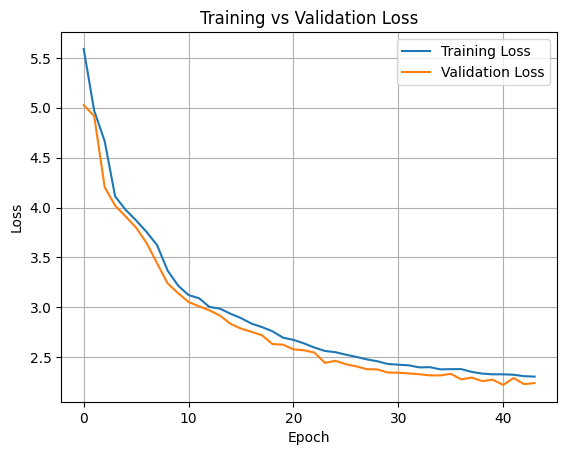

In [ ]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Generate music

We can now generate music using the trained model. We use an existing MIDI file
as a seed and generate a new sequence.

In [ ]:
import os
import pretty_midi
import matplotlib.pyplot as plt

def visualize_midi(midi_path, out_dir="tmp/", show_plot=False):
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_path)

    # Get the piano roll (shape: [128 pitches, time frames])
    piano_roll = midi_data.get_piano_roll(fs=100)

    # Plot the piano roll
    plt.figure(figsize=(12, 4))
    plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='gray_r')
    plt.xlabel('Time (frames)')
    plt.ylabel('MIDI Pitch')
    plt.title('MIDI Piano Roll')

    # Ensure output directory exists
    os.makedirs(out_dir, exist_ok=True)
    output_path = os.path.join(out_dir, os.path.basename(midi_path).replace(".mid", "_pianoroll.png"))

    # Save the figure
    plt.savefig(output_path)
    if show_plot:
        plt.show()
    else:
        plt.close()

    return f"Saved piano roll to {output_path}"


In [ ]:

def generate_music(model, seed_path, length=1024, out_dir=None, top_k=None):
    # Ensure the output directory exists
    out_dir = out_dir if out_dir is not None else tempfile.mkdtemp()
    os.makedirs(out_dir, exist_ok=True)

    # Get some tokens from the MIDI file
    inputs = midi_tokenizer.encode_midi(seed_path)[0:200]
    print(f"Seed tokens: {inputs}")

    # Generate music that follows the input tokens until the maximum length
    result = model.generate(inputs, length=length, top_k=top_k)

    output_path = path.join(out_dir, path.basename(seed_path).split(".")[0] + ".mid")
    midi_tokenizer.decode_midi(result, output_path)
    return output_path


output_file = generate_music(model, val_paths[-1], out_dir="tmp/", top_k=15)
print(visualize_midi(output_file, out_dir="tmp/"))  # Saved audio path
visualize_midi(output_file)  # Display the audio if in a Jupyter notebook

Seed tokens: [354, 363, 60, 257, 367, 68, 258, 365, 44, 257, 363, 51, 270, 179, 357, 51, 355, 355, 323, 196, 367, 68, 365, 46, 259, 179, 363, 51, 257, 361, 61, 315, 369, 67, 317, 369, 70, 315, 195, 369, 67, 279, 188, 172, 196, 198, 267, 179, 299, 365, 63, 256, 368, 68, 257, 366, 48, 257, 361, 51, 259, 195, 263, 174, 260, 189, 330, 191, 342, 176, 275, 365, 49, 256, 364, 63, 270, 366, 65, 275, 365, 67, 272, 193, 366, 65, 279, 191, 365, 63, 361, 48, 285, 177, 195, 193, 270, 179, 265, 191, 348, 367, 70, 259, 364, 63, 256, 361, 51, 363, 43, 257, 176, 264, 196, 297, 179, 257, 191, 333, 367, 72, 257, 198, 365, 63, 256, 365, 44, 257, 171, 362, 51, 302, 191, 273, 179, 264, 200, 315, 369, 72, 172, 256, 365, 43, 363, 60, 365, 70, 256, 362, 52, 316, 180, 268, 188, 261, 200, 314, 371, 72, 257, 365, 41, 367, 68, 367, 60, 365, 53, 267, 198, 256, 171, 289, 188, 256, 181, 275, 196, 260, 169, 333, 373, 73, 256, 367, 70, 366, 49, 256, 366, 37, 366, 65, 269, 200, 295, 165]
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 1

'Saved piano roll to tmp/MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_02_WAV_pianoroll.png'

In [ ]:
import pretty_midi

midi_path = "/content/tmp/MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_02_WAV.mid"
output_wav = "/content/tmp/new.wav"

# Load MIDI
midi_data = pretty_midi.PrettyMIDI(midi_path)

# Synthesize audio (requires fluidsynth or built-in synth)
audio_data = midi_data.synthesize()

# Save as WAV
from scipy.io.wavfile import write
write(output_wav, 44100, audio_data)  # 44100 Hz sample rate


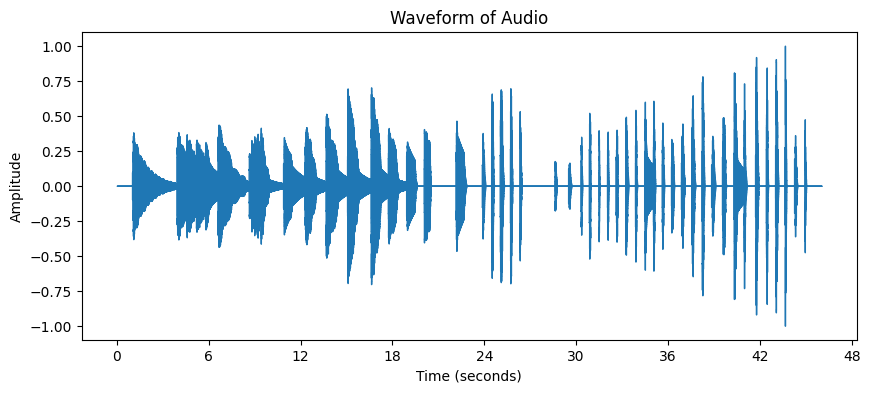

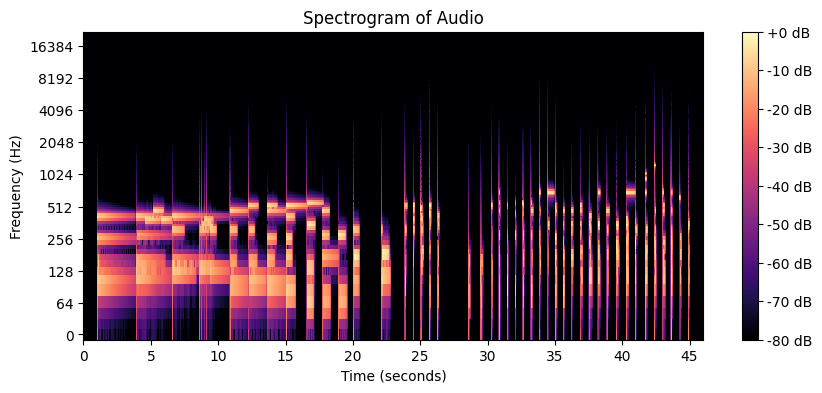

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Path of the saved audio file
audio_path = "/content/tmp/new.wav"

# Load audio file
y, sr = librosa.load(audio_path, sr=None)

# Plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of Audio")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

# Compute Spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# Plot Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram of Audio")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()


In [ ]:
print(val_paths[-1])

datasets/maestro/MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_02_WAV.midi


In [ ]:
import pickle

# Assume 'model' is your trained Transformer model
model_filename = "music_transformer.pkl"

# Save the model using pickle
with open(model_filename, "wb") as file:
    pickle.dump(model, file)

print(f"Model saved as {model_filename}")

Model saved as music_transformer.pkl
